In [1]:
#Reading Short Story as sample text

In [1]:
##Creating Tokens

In [2]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()
print(len(raw_text))
print(raw_text[:99])

20480
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [3]:
import re
preprocessed = re.split(r'([,.:;?_!"()]\'|--|\s)',raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:60])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that,', 'in', 'the', 'height', 'of', 'his', 'glory,', 'he', 'had', 'dropped', 'his', 'painting,', 'married', 'a', 'rich', 'widow,', 'and', 'established', 'himself', 'in', 'a', 'villa', 'on', 'the', 'Riviera.', '(Though', 'I', 'rather', 'thought', 'it', 'would', 'have', 'been']


In [4]:
print(len(preprocessed))

3830


In [5]:
allwords = sorted(set(preprocessed))
vocab_size = len(allwords)
print(vocab_size)

1436


In [6]:
vocab = {token:integer for integer,token in enumerate(allwords)}

In [7]:
for i,item in enumerate(vocab.items()):
    print(item)
    if i>20:
        break

('"', 0)
('"Ah', 1)
('"Ah,', 2)
('"Be', 3)
('"Begin', 4)
('"By', 5)
('"Come', 6)
('"Destroyed', 7)
('"Don\'t', 8)
('"Gisburns"', 9)
('"Grindles."', 10)
('"Hang', 11)
('"Has', 12)
('"How', 13)
('"I', 14)
('"I\'d', 15)
('"If', 16)
('"It', 17)
('"It\'s', 18)
('"Jack', 19)
('"Money\'s', 20)
('"Moon-dancers"', 21)


In [8]:
!pip3 install tiktoken


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import tiktoken
import importlib

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

In [11]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    "of someunknownPlace."
)

integers = tokenizer.encode(text,allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [12]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [13]:
import tiktoken

encodings = {
    "gpt2": tiktoken.get_encoding("gpt2"),
    "gpt3": tiktoken.get_encoding("p50k_base"),
    "gpt4": tiktoken.get_encoding("cl100k_base")
}

vocab_sizes = {model: encoding.n_vocab for model, encoding in encodings.items()}

for model, size in vocab_sizes.items():
    print(f"The vocabulary size for {model.upper()} is: {size}")

The vocabulary size for GPT2 is: 50257
The vocabulary size for GPT3 is: 50281
The vocabulary size for GPT4 is: 100277


In [14]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5146


In [15]:
!pip3 install torch


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1:i + max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

In [17]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,stride=128, shuffle=True, drop_last=True,num_workers=0):
    #Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    print(tokenizer)
    #Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    #print(dataset)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [18]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()

In [19]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4,stride=1,shuffle=False
)
#print(dataloader)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.6.0+cpu
<Encoding 'gpt2'>
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [20]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [21]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4,stride=4,shuffle=False
)

data_iter = iter(dataloader)
inputs,targets = next(data_iter)
print("Inputs:\n",inputs)
print("Targets:\n",targets)

<Encoding 'gpt2'>
Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [22]:
#implementing simplified attention mechanism

In [23]:
import torch
inputs = torch.tensor(
    [[0.43,0.15,0.89],
     [0.55,0.87,0.66],
     [0.57,0.85,0.64],
     [0.22,0.58,0.33],
     [0.77,0.25,0.10],
     [0.05,0.80,0.55]]
)

In [24]:
vocab_size = 50257
output_dim = 768  #256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [25]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

<Encoding 'gpt2'>


In [26]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n",inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [27]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 768])


In [28]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [29]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 768])


In [30]:
###Input Embedding
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 768])


In [31]:
import torch
inputs = torch.tensor(
    [[0.43,0.15,0.89], #Your
     [0.55,0.87,0.66], #journey
     [0.57,0.85,0.64], #starts
     [0.22,0.58,0.33], #with
     [0.77,0.25,0.10], #one
     [0.05,0.80,0.55]] #step
)

In [32]:
!pip3 install matplotlib
!pip3 install numpy


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


NumPy conversion successful: [1. 2. 3.]


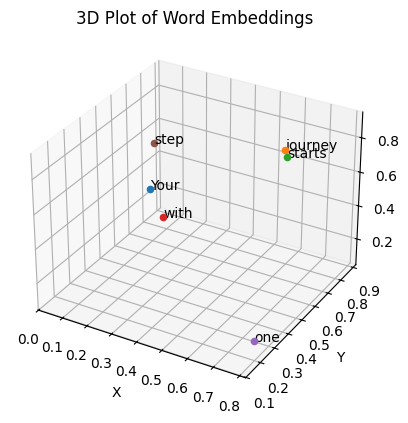

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Corresponding words
words = ['Your','journey','starts','with','one','step']

tensor = torch.tensor([1.0, 2.0, 3.0])
try:
    np_array = tensor.numpy()
    print("NumPy conversion successful:", np_array)
except Exception as e:
    print("Error:", e)

#Extract x,y,z coordinates
x_coords = inputs[:,0].numpy()
y_coords = inputs[:,1].numpy()
z_coords = inputs[:,2].numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#Plot each point and annotate with corresponding word
for x,y,z,word in zip(x_coords,y_coords,z_coords,words):
    ax.scatter(x,y,z)
    ax.text(x,y,z,word,fontsize=10)

#set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

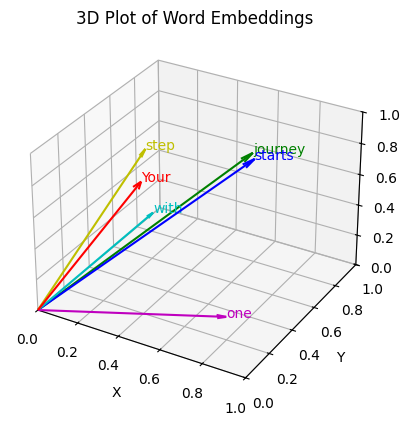

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r','g','b','c','m','y']

for (x,y,z,word,color) in zip(x_coords, y_coords, z_coords, words, colors):
    ax.quiver(0,0,0,x,y,z,color=color,arrow_length_ratio=0.05)
    ax.text(x,y,z,word,fontsize=10,color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,1])

plt.title('3D Plot of Word Embeddings')
plt.show()

In [35]:
query = inputs[1] #2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) #dot product (transpose not need)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [36]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [37]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [38]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [39]:
attn_weights = torch.softmax(attn_scores, dim=-1) #dim=-1 because we are normalising across the column in 2D matrix
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [40]:
print("All row sums:", attn_weights.sum(dim=-1))

All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [41]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [42]:
#self attention mechanism with trainaible weight
x_2=inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

In [43]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in,d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out),requires_grad=False)

In [44]:
print(W_query)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [45]:
print(W_key)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [46]:
print(W_value)

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [47]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [48]:
keys = inputs @ W_key
values = inputs @ W_value
queries = inputs @ W_query

print("keys.shape:",keys.shape)
print("values.shape:",values.shape)
print("queries.shape:",queries.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
queries.shape: torch.Size([6, 2])


In [49]:
keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [50]:
attn_scores_2 = query_2 @ keys.T #All attention scores for given query journey with other words.
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [51]:
attn_scores = queries @ keys.T # omega
print(attn_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


In [52]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


In [53]:
#why we scale it
import torch

#Define the tensor
tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])

#Apply softmax without scaling
softmax_result = torch.softmax(tensor, dim=-1)
print("Softmax without scaling:",softmax_result)

#Multiply the tensor by 8 and then apply softmax
scaled_tensor = tensor*8
softmax_scaled_result = torch.softmax(scaled_tensor, dim=-1)
print("Softmax after scaling (tensor * 8):", softmax_scaled_result)

Softmax without scaling: tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
Softmax after scaling (tensor * 8): tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


In [54]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [55]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in,d_out))
        self.W_key = nn.Parameter(torch.rand(d_in,d_out))
        self.W_value = nn.Parameter(torch.rand(d_in,d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T #omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5 , dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [56]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [57]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in,d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in,d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T #omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5 , dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [58]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [59]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [60]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [61]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [62]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [63]:
torch.triu(torch.ones(context_length, context_length), diagonal=1)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [64]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [65]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [66]:
#Masking additional attention weights with dropout
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [67]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [68]:
batch = torch.stack((inputs,inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [69]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2) # Changed transpose
        attn_scores.masked_fill_( # New, _ ops are in-place
            self.mask.bool()[:num_tokens,:num_tokens], -torch.inf) # ':num_tokens' to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores/keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) #New

        context_vec = attn_weights @ values
        return context_vec

In [70]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print('context_vecs.shape:', context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [71]:
print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


In [72]:
#Extending Single Head Attention to Multi Head Attention
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
            for _ in range(num_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [73]:
import torch
inputs = torch.tensor(
    [[0.43,0.15,0.89], #Your
     [0.55,0.87,0.66], #journey
     [0.57,0.85,0.64], #starts
     [0.22,0.58,0.33], #with
     [0.77,0.25,0.10], #one
     [0.05,0.80,0.55]] #step
)
batch = torch.stack((inputs, inputs),dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [74]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens = 6
d_in, d_out = 3,2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In [75]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads #Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_in, d_out) #Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: [b, num_tokens, d_out]
        queries = self.W_query(x)
        values = self.W_value(x)

        
        # We implicitly split the matrix by adding a 'num_heads' dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        #Transpose: (b, num_tokens, num_heads, head_dim) -> [b, num_heads, num_tokens, head_dim]
        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        #Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2,3) #Dot product for each head

        #Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        #Use the mask to fill attention scores
        attn_scores.masked_fill(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        #Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1,2)

        #Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) #optional projection

        return context_vec

In [76]:
torch.manual_seed(123)

inputs = torch.tensor(
    [
        [0.43,0.15,0.89,0.55,0.87,0.66], #Row 1
        [0.57,0.87,0.64,0.22,0.58,0.33], #Row 2
        [0.77,0.25,0.10,0.05,0.80,0.55]  #Row 3
    ]
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape",context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1189, -0.0480,  0.0313, -0.0639, -0.2789, -0.2572],
         [ 0.1202, -0.0494,  0.0326, -0.0638, -0.2786, -0.2573],
         [ 0.1189, -0.0487,  0.0325, -0.0635, -0.2795, -0.2586]],

        [[ 0.1189, -0.0480,  0.0313, -0.0639, -0.2789, -0.2572],
         [ 0.1202, -0.0494,  0.0326, -0.0638, -0.2786, -0.2573],
         [ 0.1189, -0.0487,  0.0325, -0.0635, -0.2795, -0.2586]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape torch.Size([2, 3, 6])


In [77]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length":1024, #Context length
    "emb_dim":768, #Embedding dimension
    "n_heads":12, #Number of attention head
    "n_layers":12, #Number of layers
    "drop_rate":0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}

In [78]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super(DummyGPTModel, self).__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        #A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This block does nothing and just returns its input
        return x

In [79]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 3626, 6100,  345]])


In [80]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [ 0.2673,  0.7159, -0.4726,  ..., -0.5923,  1.0530,  1.1042],
         [ 0.2423,  1.3367, -0.5303,  ...,  1.8892, -0.5572,  0.1469],
         [ 0.5900,  1.6046, -0.4373,  ...,  1.9740, -0.3847, -1.5081]]],
       grad_fn=<UnsafeViewBackward0>)


In [81]:
#GPT Architecture Part 2: Layer Normalization
torch.manual_seed(123)
batch_example = torch.randn(2,5) #A
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [82]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [83]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n",mean)
print("Variance:\n",var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [84]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [85]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [86]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [87]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

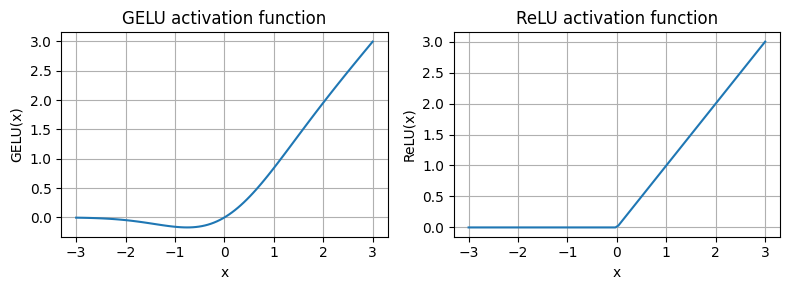

In [88]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

#Some sample data
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU","ReLU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [89]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]), # Expansion
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]) # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [90]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out=ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [91]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]), # Expansion
            GELU(), # Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]) # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [92]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back
        
        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the originalinput back

        return x

In [93]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:",x.shape)
print("Output shape:",output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [94]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [95]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOuput shape:",out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 3626, 6100,  345]])

Ouput shape: torch.Size([2, 4, 50257])
tensor([[[-0.0072, -0.2137, -0.3467,  ..., -0.3240, -0.2338, -0.1070],
         [ 0.7063, -0.7429, -0.6645,  ..., -0.6530, -0.1393, -0.2166],
         [ 0.8226, -0.2982, -0.4547,  ...,  0.0913, -0.6949, -0.2091],
         [-0.3933,  0.3074, -0.1343,  ...,  1.0464,  0.4620, -0.5298]],

        [[ 0.2689, -0.5601, -0.0403,  ..., -0.1950, -0.0047, -0.2002],
         [ 1.0315, -0.5615, -0.9067,  ..., -0.2265,  0.0185, -0.1144],
         [ 0.9909, -0.5811, -0.4749,  ...,  0.2907, -0.6347, -0.4619],
         [-0.9036, -0.1117, -0.1592,  ...,  0.8169,  0.0242, -0.6311]]],
       grad_fn=<UnsafeViewBackward0>)


In [96]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [97]:
def generate_text_simple(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):

        idx_cond = idx[:,-context_size:]

        #Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:,-1,:]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #(batch,1)

        #Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) #(batch, n_tokens+1)

    return idx
        

In [98]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [99]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:",out)
print("Output length:",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 41426, 33167, 33239]])
Output length: 10


In [100]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature IT snowballProtect youngstersMu


In [101]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length":1024, #Context length
    "emb_dim":768, #Embedding dimension
    "n_heads":12, #Number of attention head
    "n_layers":12, #Number of layers
    "drop_rate":0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() #Disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [102]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) #add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = 'Every effort moves you'
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman flaws SPLabbcats paramed jur himself CBS


In [103]:
inputs = torch.tensor([[16833,3626,6100], #['every effort moves',
                       [40,1107,588]]) # 'I really like']

targets = torch.tensor([[3626,6100,345], #['effort moves you',
                       [1107,588,11311]]) # 'really like chocolate']

In [104]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) #Probability of each token in voc
print(probas.shape) #Shape: (batch_size, num_tokens,vocab_size)

torch.Size([2, 3, 50257])


In [105]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print('Token IDs:\n', token_ids)

Token IDs:
 tensor([[[31894],
         [36134],
         [20610]],

        [[37537],
         [17925],
         [47105]]])


In [106]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  chargerJerFriday


In [107]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:",target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


In [108]:
#Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.3800, -10.8884, -11.2438,  -9.9803, -11.0496, -11.3056])


In [109]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8079)


In [110]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8079)


In [111]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [112]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8079)


In [113]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(49411.9766)


In [114]:
import os
import urllib.request

file_path = 'the-verdict.txt'
url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter'
text_data = ''
if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path,'w',encoding='utf-8') as file:
        file.write(text_data)

else:
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.read()

In [115]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [116]:
print(text_data[-99:])

t for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."



In [117]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:",total_characters)
print("Tokens:", total_tokens)

Characters: 20480
Tokens: 5146


In [118]:
train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'], drop_last=True, shuffle=True, num_workers=0
)

val_loader = create_dataloader_v1(
    val_data, batch_size=2, max_length=GPT_CONFIG_124M['context_length'], stride=GPT_CONFIG_124M['context_length'], drop_last=False, shuffle=False, num_workers=0
)
print(total_tokens * (train_ratio))

<Encoding 'gpt2'>
<Encoding 'gpt2'>
4116.8


In [119]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the training loader."
          "Try to lower the GPT_CONFIG"
    )

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the validation loader."
          "Try to lower the GPT_CONFIG"
    )

In [120]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])

Validation loader:
torch.Size([1, 1024]) torch.Size([1, 1024])
2


In [121]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("Total tokens:", train_tokens + val_tokens)

Training tokens: 4096
Validation tokens: 1024
Total tokens: 5120


In [122]:

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches= None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        #Reduce the number of batches to match the total number of batches in the data loader
        #if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader
 
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)
    

Training loss: 11.000012874603271
Validation loss: 11.023253440856934


In [124]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):

    #Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1

    #Main training loop
    for epoch in range(num_epochs):
        model.train() #Set model tot training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() #Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or token) in the input_batch
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"EP {epoch+1} (Step {global_step:06d}):"
                     f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        #print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [125]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [126]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decode_text = token_ids_to_text(token_ids, tokenizer)
    print(decode_text.replace("\n"," ")) #compact print format
    model.train()

In [127]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,eval_freq=1,eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

EP 1 (Step 000000):Train loss 9.636, Val loss 10.013
EP 1 (Step 000001):Train loss 9.121, Val loss 9.387
Every effort moves you, the, the,,, the, the,,, the, the.                                 
EP 2 (Step 000002):Train loss 8.666, Val loss 9.038
EP 2 (Step 000003):Train loss 8.168, Val loss 8.715
Every effort moves you, the, the, the, the, the,, the, the, the, the,, the, the, the,, the, the,,,,, the, the.          
EP 3 (Step 000004):Train loss 7.788, Val loss 8.381
EP 3 (Step 000005):Train loss 7.345, Val loss 8.105
Every effort moves you, the, the, the, the, the, the.                                     
EP 4 (Step 000006):Train loss 6.873, Val loss 7.842
EP 4 (Step 000007):Train loss 6.322, Val loss 7.638
Every effort moves you, the, the, the, the, the, the.                                     
EP 5 (Step 000008):Train loss 6.232, Val loss 7.738
EP 5 (Step 000009):Train loss 5.577, Val loss 7.122
Every effort moves you, and, and, and, and, and, and. ", and, and, and the. Gisburn, 

In [128]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [129]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n",token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisburn's an


In [130]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79] 
)

probas = torch.softmax(next_token_logits, dim = 0)
print(probas)
#Temperature values
temperatures = [1, 0.1 , 5] #Original, higher confidence, and lower confidence

#Calculate scaled probablities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])


In [131]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top logits:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top logits: tensor([3, 7, 0])


In [132]:
new_logits = torch.where(
    condition=next_token_logits<top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [133]:
topk_probas = torch.softmax(new_logits, dim = 0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [134]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    #For-loop is the same as before: Get logits and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        #New: Filter logits with top_K sampling
        if top_k is not None:
            #keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits<min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        #New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            #Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1) # (batch_size, context_len)
           
            #Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) #(batch_size,1)
            
        # Otherwise same as before: get idx of the vocab entry with highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  #(batch_size,1)
            
        if idx_next == eos_id:
            break
        #print(idx)
        #print(idx_next)
        idx = torch.cat((idx, idx_next), dim=1) #(batch_size,1)

    return idx

In [135]:
import torch
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.2
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know I Gisburn rather a little it was no my eyes grew enough


In [136]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [137]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [138]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [11]:
import io
import torch
# Load the checkpoint file into a buffer
with open("model_and_optimizer.pth", "rb") as f:
    buffer = io.BytesIO(f.read())

# Load the checkpoint from the buffer
#checkpoint = torch.load(buffer)
checkpoint = torch.load("model_and_optimizer.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

NameError: name 'GPTModel' is not defined

In [ ]:
!pip3 install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

In [ ]:
# %load gpt_download3.py
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    #load setting and params
    print(os.path.join(models_dir, "hparams.json"))
    tf_ckpt_path = tf.train.latest_checkpoint(models_dir)
    settings = json.load(open(os.path.join(models_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path,settings)
    return settings, params

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    #initializae parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    #Iterate over each variable on the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        #Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:] #skip the 'model/' prefix
 
        #Identity the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        #Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key,{})

        #Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


In [ ]:
settings, params = download_and_load_gpt2(model_size="124M",models_dir="gpt2\\124M")

In [ ]:
print("Settings:",settings)
print("Parameter dictionary keys:", params.keys())

In [ ]:
print(params["wte"])
print("Token Embedding weight tensor dimensions:", params["wte"].shape)

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length":1024, #Context length
    "emb_dim":768, #Embedding dimension
    "n_heads":12, #Number of attention head
    "n_layers":12, #Number of layers
    "drop_rate":0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}
NEW_CONFIG = GPT_CONFIG_124M.copy()
print(NEW_CONFIG)

In [ ]:
NEW_CONFIG.update({"context_length": 1024,"qkv_bias":True})
print(NEW_CONFIG)

In [15]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

NameError: name 'GPTModel' is not defined

In [12]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [13]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [14]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

NameError: name 'gpt' is not defined

In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=20,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))